# feature engineering

### setup

In [3]:
PROP=1/100

#configure for local mimic databse
exec(open("../configs/configure_mimic.py").read())
exec(open("my_functions.py").read())


Configured for local MIMIC database:
	user = postgres
	dbname = mimic
	host = localhost
	schema_name = mimiciii
	query_schema = SET search_path to mimiciii;

Configured for my local MIMIC database (modified tables):
	my_username = postgres
	my_dbname = mimic
	host = localhost
	my_schema_name = my_mimic_db
	my_schema = SET search_path to my_mimic_db;


## demographics
From admissions and patients tables

2480


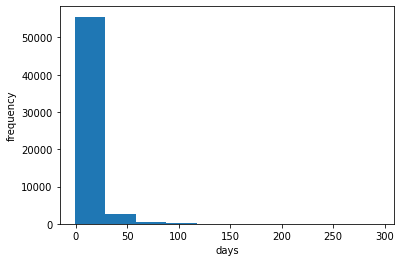

In [4]:
#load admission data along with outcomes desginated in build_outcome.ipynb
#adat = pd.read_csv('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/outcome_penalizable_dat.csv')
query = """
SELECT * FROM outcome_penalizable_dat;
"""
adat = pd.read_sql_query(query,my_con)
print(np.sum(adat['hrrd_penalized']))

#add stay duration
adat['stay_duration'] = pd.to_datetime(adat['dischtime']) - pd.to_datetime(adat['admittime'])
adat['stay_duration'] = pd.to_timedelta(adat['stay_duration'], unit='D')/datetime.timedelta(days=1)
plt.hist(adat['stay_duration'])
plt.xlabel('days')
plt.ylabel('frequency');

#subset for useful variables and remove patients with deathtimes
adat = adat.loc[adat['deathtime'].isna(), ['subject_id', 'hadm_id', 'admittime', 'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'hospital_expire_flag', 'stay_duration', 'hrrd_penalized']]

In [5]:
#load patient data
query = query_schema + \
"""select 
    subject_id,
    gender,
    dob
    from patients"""
pdat = pd.read_sql_query(query,con)

#merge them
odat = pd.merge(adat, pdat, how = 'inner', on='subject_id')
odat['dob_dt'] = pd.to_datetime(odat['dob']).dt.date
odat['admittime_dt'] = pd.to_datetime(odat['admittime']).dt.date
odat['age'] = odat.apply(lambda e: (e['admittime_dt'] - e['dob_dt']).days/365, axis=1)
odat.loc[odat['age']>200, 'age'] = 91
odat = odat.loc[odat['age']>18, ['subject_id', 'hadm_id', 'hrrd_penalized', 'discharge_location', 'insurance',
       'language', 'religion', 'marital_status', 'ethnicity',
       'gender', 'age']]
odat.index = odat['hadm_id']
odat.drop(columns = ['hadm_id', 'subject_id'])

,hrrd_penalized,discharge_location,insurance,language,religion,marital_status,ethnicity,gender,age
hadm_id,,,,,,,,,
165315,0,DISC-TRAN CANCER/CHLDRN H,Private,None,UNOBTAINABLE,MARRIED,WHITE,F,64.969863
152223,0,HOME HEALTH CARE,Medicare,None,CATHOLIC,MARRIED,WHITE,M,71.178082
124321,0,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,M,75.304110
161859,0,HOME,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,M,39.041096
129635,0,HOME,Private,None,UNOBTAINABLE,MARRIED,WHITE,M,58.989041
...,...,...,...,...,...,...,...,...,...
141860,0,SNF,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,F,80.389041
187987,0,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,M,53.613699
190603,0,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,M,78.326027


#### handle missing values

In [6]:
# print(np.sum(odat.isnull()))
odat.loc[odat['language'].isna(), 'language'] = 'missing'
odat.loc[odat['religion'].isna(), 'religion'] = 'missing'
odat.loc[odat['marital_status'].isna(), 'marital_status'] = 'missing'
# print(np.sum(odat.isnull()))

#### age distribution

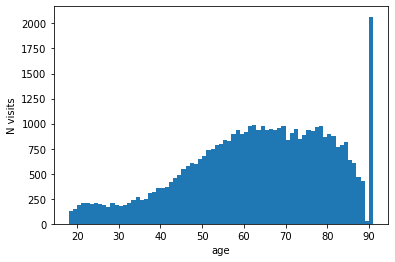

In [7]:
plt.hist(odat['age'], bins = 91-18);
plt.xlabel('age')
plt.ylabel('N visits')
plt.show();

### add icu features
add total time spent in icu and total icu visits

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


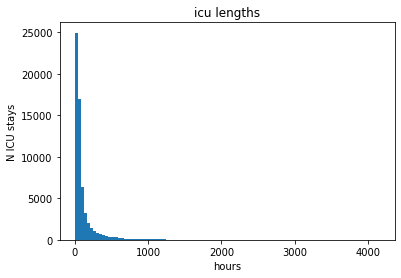

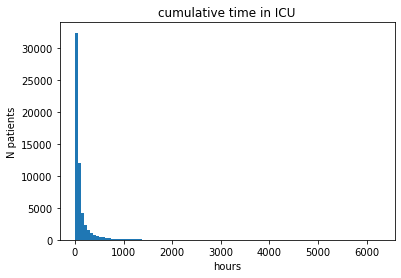

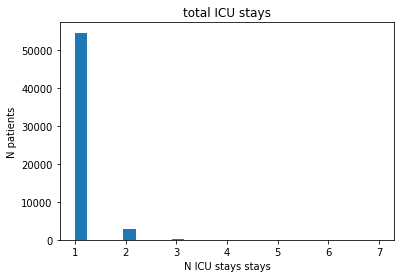

In [8]:
#load patient data
query = query_schema + \
"""select 
    *
    from ICUSTAYS"""
idat = pd.read_sql_query(query,con)



idat['icu_duration'] = idat['outtime'] - idat['intime']
idat['icu_duration'] = pd.to_timedelta(idat['icu_duration'], unit='hr')/datetime.timedelta(hours=1)

#plot icu hours
plt.hist(idat['icu_duration'], bins=100)
plt.title('icu lengths')
plt.xlabel('hours')
plt.ylabel('N ICU stays')
plt.show()

#organize icu stay features
total_time = idat.loc[:,['icu_duration', 'hadm_id']].groupby(['hadm_id']).sum()
total_icu_visits = idat.loc[:,['hadm_id', 'icustay_id']].groupby(['hadm_id']).count()
total_icu_visits.columns = ['nicu_stays']
total_icu_visits.index.name = 'hadm_id'
icu_features = pd.merge(total_time, total_icu_visits, how='inner', on='hadm_id')

#plot cumulative icu time
plt.hist(icu_features['icu_duration'], bins=100)
plt.title('cumulative time in ICU')
plt.xlabel('hours')
plt.ylabel('N patients')
plt.show()

#plot total ICU stays
plt.hist(icu_features['nicu_stays'], bins=25)
plt.title('total ICU stays')
plt.xlabel('N ICU stays stays')
plt.ylabel('N patients')
plt.show()

#add to odat
odat = pd.merge(odat.drop(columns='hadm_id'), icu_features, how = 'inner', on = 'hadm_id')

## Train-test splitting

In [9]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

odat['hadm_id'] = odat.index
y = odat['hrrd_penalized']
X = odat.drop([
    'hrrd_penalized'], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=321, stratify=y)
print(np.sum(y_train))
print(np.sum(y_test))
all_hadm_ids = odat['hadm_id']
train_hadm_ids = X_train['hadm_id']
test_hadm_ids = X_test['hadm_id']
train_pos_hadm_ids = train_hadm_ids[y==1]
len(train_pos_hadm_ids)
X_train.drop(['subject_id', 'hadm_id'], 1)
X_test.drop(['subject_id', 'hadm_id'], 1)

#write out outcomes
import joblib
joblib.dump(y_train, my_local_data_dir + 'y_train.joblib');

1724
431


## Funcitons for feature selection

In [10]:
def filter_by_presence_in_pos(input_df, pos_ids, feature_col, prop=1/50):
    """Function to remove features unlikely to be informative for outcome.
    df = the input predictors
    pos_ids = the positive hadm_ids
    feature_col = the column of features (eg prescriptions, diagnoses, procedures) given to patient
    prop = the proportion of positive patients the feature must have occured in to keep it"""
    pos_df = input_df.loc[input_df['hadm_id'].isin(pos_ids),]
    occurance = pos_df[feature_col].value_counts()
    keep_features = occurance.index[occurance > (len(pos_ids)*prop)]
    print('{} features found among >= {}% of positive cases'.format(len(keep_features), prop*100))
    return input_df.loc[input_df[feature_col].isin(keep_features),:]


def filter_by_presence_in_general(input_df, feature_col, prop=1/100):
    """Function to remove features unlikely to be informative for outcome because rare in dataset.
    input_df = the input predictors
    feature_col = the column of features (eg prescriptions, diagnoses, procedures) given to patient
    prop = the proportion of hadm_ids the feature must have occured in to keep it"""
    occurance = input_df[feature_col].value_counts()
    keep_features = occurance.index[occurance > (len(input_df['hadm_id'].unique())*prop)]
    print('{} features found among >= {}% of positive cases'.format(len(keep_features), prop*100))
    return input_df.loc[input_df[feature_col].isin(keep_features),:]

from sklearn.preprocessing import MinMaxScaler
def onehot_features(long_df, feature_col):
    to_onehot = [feature_col]
    raw_oh_dat = pd.get_dummies(long_df, columns = to_onehot, drop_first = True)
    summed_dat = raw_oh_dat.groupby('hadm_id').sum()
    bool_dat = summed_dat > 0
    oh_dat = bool_dat.astype('int')
    total_col = 'total_{}'.format(feature_col)
    oh_dat[total_col] = oh_dat.sum(axis=1)
    scaler = MinMaxScaler()
    oh_dat[[total_col]] = scaler.fit_transform(oh_dat[[total_col]])
    return oh_dat

#function to combine all above
def select_presence_absence_features(input_df, all_ids, train_ids, pos_ids, feature_col, prop, y_train):
    filt_pos = filter_by_presence_in_pos(input_df, pos_ids, feature_col, prop)
    filt_gen = filter_by_presence_in_general(input_df, feature_col, prop=prop)
    keep = pd.concat([filt_pos, filt_gen], 0)
    filt_df = input_df.loc[input_df[feature_col].isin(keep[feature_col])]
    print('{} features total unique feature kept for selection'.format(len(filt_df[feature_col].unique()), prop*100))
    oh_dat = onehot_features(filt_df, feature_col)
    return oh_dat

    
#vars for recording
dat_dict = {'odat': odat}
dat_list = ['odat']

## add presence absence features

## services

In [11]:
#load patient data
query = query_schema + \
"""select 
    hadm_id,
    curr_service
    from SERVICES"""
serv_dat = pd.read_sql_query(query,con)
serv_dat = select_presence_absence_features(input_df = serv_dat,
                                            all_ids = all_hadm_ids,
                                          train_ids = train_hadm_ids,
                                          pos_ids = train_pos_hadm_ids,
                                          feature_col = 'curr_service',
                                          prop=PROP,
                                          y_train = y_train)
dat_dict['services'] = serv_dat
dat_list.append('services')
serv_dat.shape

11 features found among >= 1.0% of positive cases
12 features found among >= 1.0% of positive cases
12 features total unique feature kept for selection


(58029, 12)

### diagnoses

In [12]:
#load patient data
query = query_schema + \
"""select 
    hadm_id,
    icd9_code
    from DIAGNOSES_ICD"""
ddat = pd.read_sql_query(query,con)
ddat = ddat.rename(columns = {'icd9_code':'diagnosis_icd9'})
print('total unique diagnoses = {}'.format(len(ddat['diagnosis_icd9'].unique())))
ddat = select_presence_absence_features(input_df = ddat,
                                        all_ids = all_hadm_ids,
                                          train_ids = train_hadm_ids,
                                          pos_ids = train_pos_hadm_ids,
                                          feature_col = 'diagnosis_icd9',
                                          prop=PROP,
                                          y_train = y_train)
dat_dict['diagnoses'] = ddat
dat_list.append('diagnoses')
ddat.shape

total unique diagnoses = 6985
261 features found among >= 1.0% of positive cases
211 features found among >= 1.0% of positive cases
290 features total unique feature kept for selection


(57849, 290)

### procedures

In [13]:
#load patient data
query = query_schema + \
"""select 
    hadm_id,
    icd9_code
    from PROCEDURES_ICD"""
proc_dat = pd.read_sql_query(query, con)
proc_dat = proc_dat.rename(columns = {'icd9_code':'procedure_icd9'})
print('total unique procedures = {}'.format(len(proc_dat['procedure_icd9'].unique())))
proc_dat = select_presence_absence_features(input_df = proc_dat,
                                            all_ids = all_hadm_ids,
                                          train_ids = train_hadm_ids,
                                          pos_ids = train_pos_hadm_ids,
                                          feature_col = 'procedure_icd9',
                                          prop=PROP,
                                          y_train = y_train)
dat_dict['procedures'] = proc_dat
dat_list.append('procedures')
proc_dat.shape

total unique procedures = 2032
62 features found among >= 1.0% of positive cases
72 features found among >= 1.0% of positive cases
77 features total unique feature kept for selection


(47887, 77)

### prescriptions

In [14]:
#load patient data
query = query_schema + \
"""select 
    hadm_id,
    drug
    from PRESCRIPTIONS"""
drug_dat = pd.read_sql_query(query, con)
drug_dat = select_presence_absence_features(input_df = drug_dat,
                                            all_ids = all_hadm_ids,
                                          train_ids = train_hadm_ids,
                                          pos_ids = train_pos_hadm_ids,
                                          feature_col = 'drug',
                                          prop=1/10,
                                          y_train = y_train)
dat_dict['drugs'] = drug_dat
dat_list.append('drugs')
drug_dat.shape

136 features found among >= 10.0% of positive cases
146 features found among >= 10.0% of positive cases
153 features total unique feature kept for selection


(49847, 153)

### icu wards
Here we get all the ICU wards the pateint was exposed to

In [15]:
#care unit
careunit_dat = select_presence_absence_features(input_df = idat,
                                            all_ids = all_hadm_ids,
                                          train_ids = train_hadm_ids,
                                          pos_ids = train_pos_hadm_ids,
                                          feature_col = 'last_careunit',
                                          prop=1/50,
                                          y_train = y_train)
careunit_dat = careunit_dat.drop(columns = ['row_id', 'subject_id', 'icustay_id', 'first_wardid', 'last_wardid',
       'los', 'icu_duration'])
if careunit_dat.shape[0] > 0:
    dat_dict['care_unit'] = careunit_dat
    dat_list.append('care_unit')
    careunit_dat.shape

#ward
ward_dat = select_presence_absence_features(input_df = idat,
                                            all_ids = all_hadm_ids,
                                          train_ids = train_hadm_ids,
                                          pos_ids = train_pos_hadm_ids,
                                          feature_col = 'last_wardid',
                                          prop=1/50,
                                          y_train = y_train)
ward_dat = ward_dat.drop(columns = ['row_id', 'subject_id', 'icustay_id', 'first_wardid', 'icu_duration', 'los'])
if careunit_dat.shape[0] > 0:
    dat_dict['ward'] = ward_dat
    dat_list.append('ward')
    ward_dat.shape

5 features found among >= 2.0% of positive cases
6 features found among >= 2.0% of positive cases
6 features total unique feature kept for selection
9 features found among >= 2.0% of positive cases
10 features found among >= 2.0% of positive cases
10 features total unique feature kept for selection


### add discharge note features

In [16]:
#option to load from csv
# ndat = pd.read_csv(my_local_data_dir + 'discharge_note_features.csv', index_col='hadm_id') #build this with discharge_notes.ipynb

#load from my_mimic_db
query = """
SELECT * FROM discharge_note_features;
"""
ndat = pd.read_sql_query(query,my_con)
ndat.index = ndat['hadm_id']
ndat = ndat.drop(columns = 'hadm_id')
ndat.columns = ['DNword_' + x for x in ndat.columns]
dat_dict['dnotes'] = ndat
dat_list.append('dnotes')
ndat.columns
ndat.shape

(52704, 27)

## combine

In [17]:
#set up new datafrom to merge up selected features into
cdat = odat.copy()
cdat = cdat.drop(columns = ['hadm_id'])

#select the unique values from dat_list with same order
dl = []
for d in dat_list:
    if d not in dl:
        dl.append(d)

#merge them all
for d in dl:
    if d != 'odat':
        to_add = dat_dict[d]
        print(d)
        cdat = pd.merge(cdat, dat_dict[d], how = 'left', on='hadm_id')

#remove non-predictors 
y = cdat['hrrd_penalized'].astype('int')
cdat = cdat.drop(columns = ['subject_id', 'hrrd_penalized'])
cdat.shape

services
diagnoses
procedures
drugs
care_unit
ward
dnotes


(43956, 585)

### handle missing values

In [18]:
missing = cdat.isnull().sum()
cols_w_missing = missing[missing>0].index

#imput totals with mean
totals_w_missing = cols_w_missing[cols_w_missing.str.contains('total_')]
for tc in totals_w_missing:
    cdat[tc] = cdat[tc].fillna(cdat[tc].mean())

#imput the categorical cols
categorical_w_missing = cols_w_missing[~cols_w_missing.isin(totals_w_missing)]
for cc in categorical_w_missing:
    cdat[cc] = cdat[cc].fillna(0)


### onehot encode categorical features that need it

In [19]:
#onehot encode the pdat columns
to_onehot = ['discharge_location', 
             'insurance', 
             'language',
             'religion', 
             'marital_status',
             'ethnicity',
            'gender']
cdat = pd.get_dummies(cdat, columns = to_onehot, drop_first = True)
cdat

,age,icu_duration,nicu_stays,curr_service_CSURG,curr_service_MED,curr_service_NB,curr_service_NMED,curr_service_NSURG,curr_service_OMED,curr_service_ORTHO,...,ethnicity_PORTUGUESE,ethnicity_SOUTH AMERICAN,ethnicity_UNABLE TO OBTAIN,ethnicity_UNKNOWN/NOT SPECIFIED,ethnicity_WHITE,ethnicity_WHITE - BRAZILIAN,ethnicity_WHITE - EASTERN EUROPEAN,ethnicity_WHITE - OTHER EUROPEAN,ethnicity_WHITE - RUSSIAN,gender_M
hadm_id,,,,,,,,,,,,,,,,,,,,,
165315,64.969863,27.450000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
152223,71.178082,30.337778,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
124321,75.304110,28.469444,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
161859,39.041096,12.296944,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
129635,58.989041,85.117778,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141860,80.389041,186.932500,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
187987,53.613699,78.476667,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,1,0,0,0,0,1
190603,78.326027,54.931111,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1


### scale for all features to be between zero and one

In [20]:
#Note the 'total' columns created for presence absence sets above are already scaled
#scale the dataframe
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
need_scaling = [
    'age', 'icu_duration', 'nicu_stays'
]
cdat[need_scaling] = scaler.fit_transform(cdat[need_scaling])
print('maximum value in dataframe = {}'.format(max(cdat.max())))

maximum value in dataframe = 1.0


### handle colinearity between features
greedily take the member of each pair that correlates better with outcome

In [21]:
#get highly correlated pairs
CORRELATION_CUT = 0.75
m = cdat.corr()
cor_df = m.stack().reset_index()
cor_df.columns = ['f1', 'f2', 'cor']
cor_df = cor_df.loc[cor_df['f1']!=cor_df['f2'],:]
hcor_df = cor_df.loc[np.abs(cor_df['cor'])>CORRELATION_CUT,:]
sorted_pairs = pd.DataFrame(hcor_df.loc[:,['f1','f2']].apply(lambda x: x.sort_values().values, axis=1))
dups = pd.DataFrame(sorted_pairs[0].tolist(), index= sorted_pairs.index).duplicated()
hcor_df = hcor_df.loc[~dups,:]

#drop the lesser of the two
def col_outcome_cor(col):
    c = cdat[col].corr(y)
    return(c)
col_outcome_cor('curr_service_CSURG')
hcor_df['f1c'] = hcor_df['f1'].apply(col_outcome_cor)
hcor_df['f2c'] = hcor_df['f2'].apply(col_outcome_cor)
f1_higher = hcor_df['f1c'] >= hcor_df['f2c']
drop_count = 0
print('correlated feature pairs:')
for i in range(len(f1_higher)):
    f1 = hcor_df.loc[hcor_df.index[i],'f1']
    f2 = hcor_df.loc[hcor_df.index[i],'f2']
    compare = f1_higher.loc[f1_higher.index[i]]
    if compare:
        to_drop = f2
    else:
        to_drop=f1
    if str(to_drop) in cdat.columns:
        cdat = cdat.drop(columns=[to_drop])
        drop_count += 1
        print('{} - {}... dropped {}'.format(f1,f2,to_drop))
print('{} features from {} feature pairs with correlations > 0.75 were dropped'.format(drop_count, hcor_df.shape[0]))

correlated feature pairs:
curr_service_CSURG - procedure_icd9_3961... dropped procedure_icd9_3961
curr_service_CSURG - drug_Glycopyrrolate... dropped curr_service_CSURG
curr_service_CSURG - drug_Neostigmine... dropped drug_Neostigmine
curr_service_CSURG - last_careunit_CSRU... dropped last_careunit_CSRU
diagnosis_icd9_2449 - drug_Levothyroxine Sodium... dropped drug_Levothyroxine Sodium
diagnosis_icd9_29410 - diagnosis_icd9_3310... dropped diagnosis_icd9_29410
drug_Aspirin EC - drug_Neostigmine... dropped drug_Aspirin EC
drug_Dextrose 50% - drug_Glucagon... dropped drug_Dextrose 50%
drug_Famotidine - drug_Iso-Osmotic Sodium Chloride... dropped drug_Iso-Osmotic Sodium Chloride
drug_Glycopyrrolate - drug_Nitroglycerin... dropped drug_Glycopyrrolate
total_last_careunit - total_last_wardid... dropped total_last_wardid
insurance_Medicare - insurance_Private... dropped insurance_Private
language_ENGL - language_missing... dropped language_missing
13 features from 22 feature pairs with correl

### set training for feature selection

In [22]:
X_train_fs = cdat.loc[train_hadm_ids,:]
y_train_fs = y[train_hadm_ids]
print(X_train_fs.shape)
print(len(y_train_fs))
print(np.sum(y_train))

(35164, 724)
35164
1724


## Feature selection

#### optimize hyperparameters for RF

In [23]:
#------- OPTIMIZE RF
RAND_SEED=321
N_JOBS=1
#use RandomizedSearchCV() to optimized Random forest hyperparameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
rf_clf = RandomForestClassifier()

#choose parameter grid values
max_depth = [10,20,30,40]
min_samples_split = [2]
min_samples_leaf = [1]

#make grid dict
random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


# ### run random search
rf_search = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               scoring = 'recall',
                               cv = 4,
                               verbose=2,
                               random_state=RAND_SEED,
                               n_jobs = N_JOBS)
rf_search.fit(X_train_fs, y_train_fs)
best_params = rf_search.best_params_
print(rf_search.best_params_)



Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=10 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=10, total=   2.9s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=10 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=10, total=   2.9s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=10 ...........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=10, total=   2.9s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=10 ...........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=10, total=   2.9s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=20 ...........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=20, total=   5.8s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=20 ...........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=20, total=   5.9s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=20 ...........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=20, total=   5.9s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=20 ...........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=20, total=   5.9s
[CV] min_samples_split=2, min_samples_leaf=1, max

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  1.7min finished


{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}


#### fit model with optimized hyperparameters

In [24]:
#set up optimized rf model based on from best_params above
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
print(best_params)
rf_opt = RandomForestClassifier(n_jobs=N_JOBS,
                                min_samples_split = best_params['min_samples_split'],
                                min_samples_leaf = best_params['min_samples_leaf'],
                                max_depth = best_params['max_depth'],
                                bootstrap = True,
                               random_state=RAND_SEED)

#train
rf_opt.fit(X_train_fs, y_train_fs)

{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}


RandomForestClassifier(max_depth=30, n_jobs=1, random_state=321)

#### look at feature importances from optimized model

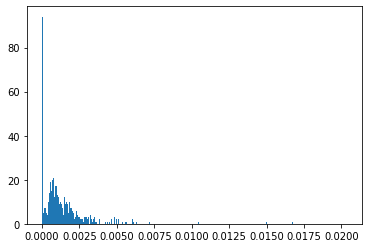

In [25]:
importances = rf_opt.feature_importances_
plt.hist(importances, bins=500)
plt.show()

### select optimal importance cutoff via cross fold validation

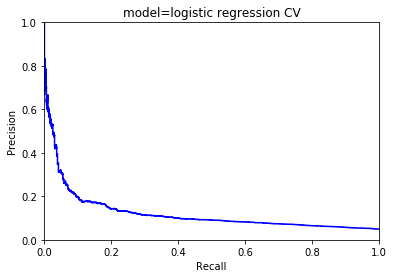

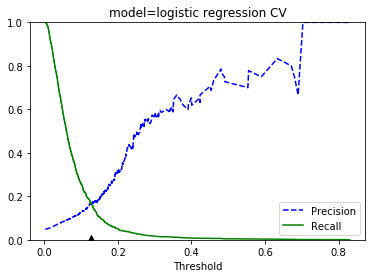

Confusion matrix for threshold = 0.13:
[[32007  1433]
 [ 1434   290]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     33440
           1       0.17      0.17      0.17      1724

    accuracy                           0.92     35164
   macro avg       0.56      0.56      0.56     35164
weighted avg       0.92      0.92      0.92     35164



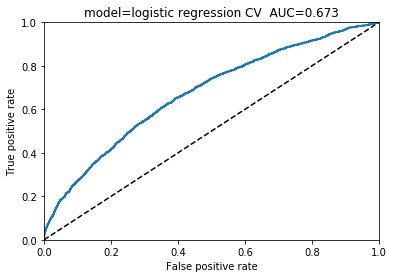

0.673
----------
Importance cutoff = 0.0002
Features passing = 606
Kept length = 606
(35164, 606)
Resulting AUC = 0.673


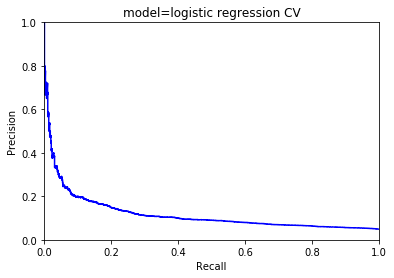

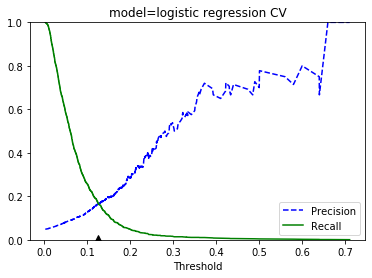

Confusion matrix for threshold = 0.13:
[[32001  1439]
 [ 1440   284]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     33440
           1       0.16      0.16      0.16      1724

    accuracy                           0.92     35164
   macro avg       0.56      0.56      0.56     35164
weighted avg       0.92      0.92      0.92     35164



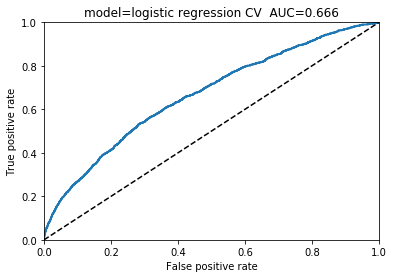

0.666
----------
Importance cutoff = 0.0004
Features passing = 574
Kept length = 574
(35164, 574)
Resulting AUC = 0.666


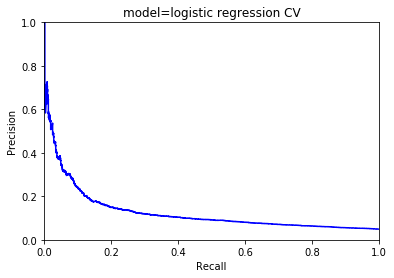

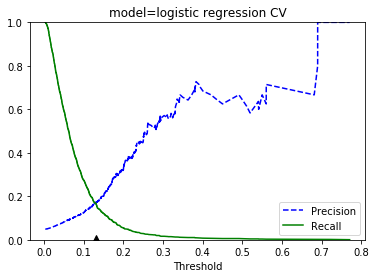

Confusion matrix for threshold = 0.13:
[[32007  1433]
 [ 1434   290]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     33440
           1       0.17      0.17      0.17      1724

    accuracy                           0.92     35164
   macro avg       0.56      0.56      0.56     35164
weighted avg       0.92      0.92      0.92     35164



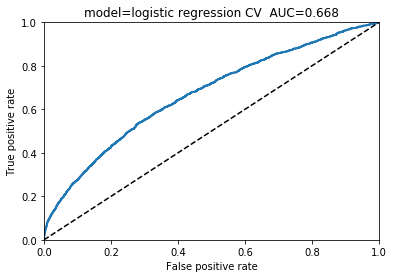

0.668
----------
Importance cutoff = 0.0006
Features passing = 513
Kept length = 513
(35164, 513)
Resulting AUC = 0.668


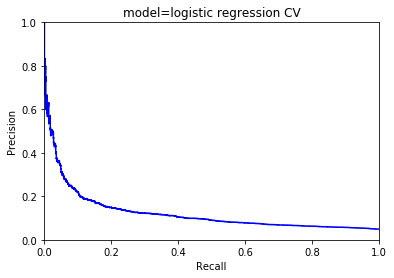

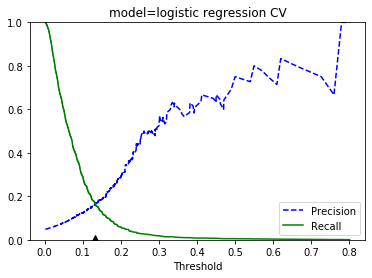

Confusion matrix for threshold = 0.13:
[[32002  1438]
 [ 1439   285]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     33440
           1       0.17      0.17      0.17      1724

    accuracy                           0.92     35164
   macro avg       0.56      0.56      0.56     35164
weighted avg       0.92      0.92      0.92     35164



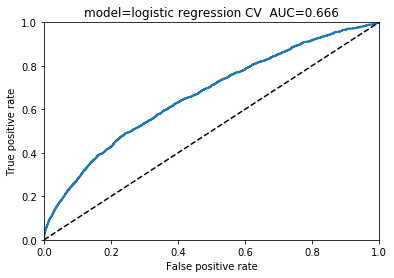

0.666
----------
Importance cutoff = 0.0008
Features passing = 426
Kept length = 426
(35164, 426)
Resulting AUC = 0.666


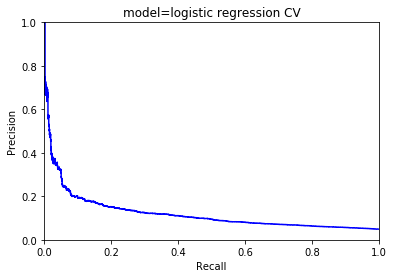

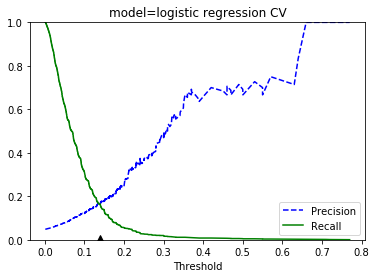

Confusion matrix for threshold = 0.14:
[[32001  1439]
 [ 1440   284]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     33440
           1       0.16      0.16      0.16      1724

    accuracy                           0.92     35164
   macro avg       0.56      0.56      0.56     35164
weighted avg       0.92      0.92      0.92     35164



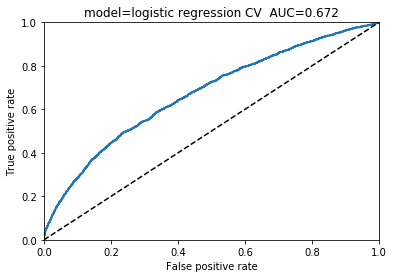

0.672
----------
Importance cutoff = 0.001
Features passing = 351
Kept length = 351
(35164, 351)
Resulting AUC = 0.672


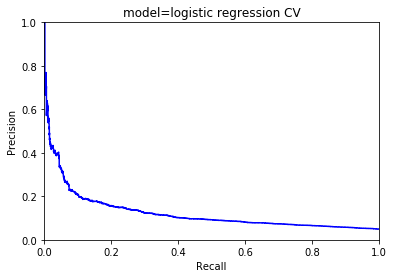

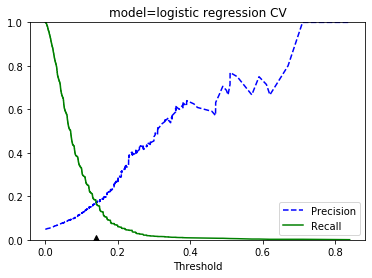

Confusion matrix for threshold = 0.14:
[[32012  1428]
 [ 1429   295]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     33440
           1       0.17      0.17      0.17      1724

    accuracy                           0.92     35164
   macro avg       0.56      0.56      0.56     35164
weighted avg       0.92      0.92      0.92     35164



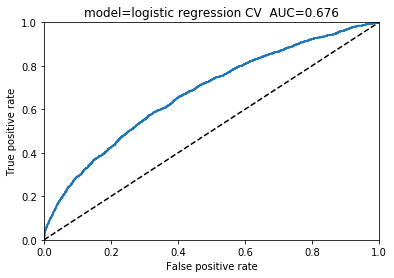

0.676
----------
Importance cutoff = 0.0012
Features passing = 294
Kept length = 294
(35164, 294)
Resulting AUC = 0.676


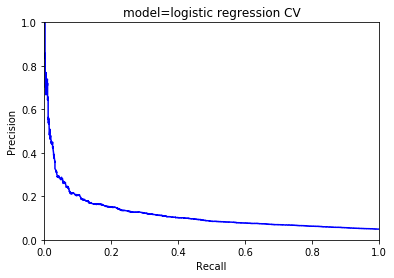

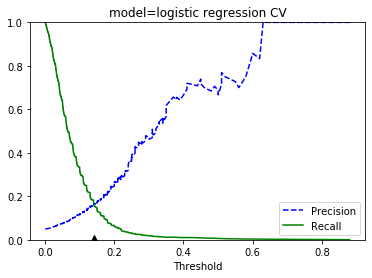

Confusion matrix for threshold = 0.14:
[[31999  1441]
 [ 1442   282]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     33440
           1       0.16      0.16      0.16      1724

    accuracy                           0.92     35164
   macro avg       0.56      0.56      0.56     35164
weighted avg       0.92      0.92      0.92     35164



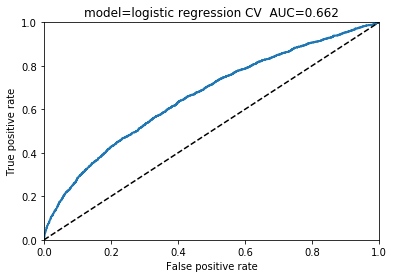

0.662
----------
Importance cutoff = 0.0014
Features passing = 257
Kept length = 257
(35164, 257)
Resulting AUC = 0.662


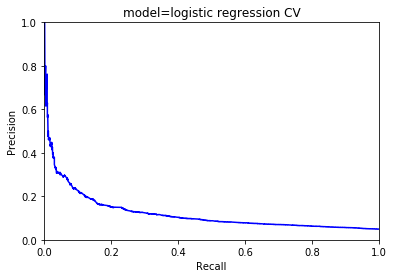

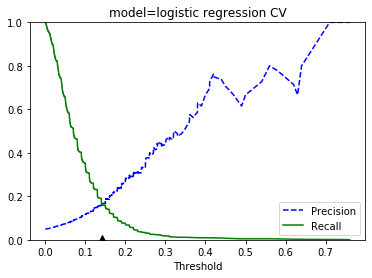

Confusion matrix for threshold = 0.14:
[[32001  1439]
 [ 1440   284]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     33440
           1       0.16      0.16      0.16      1724

    accuracy                           0.92     35164
   macro avg       0.56      0.56      0.56     35164
weighted avg       0.92      0.92      0.92     35164



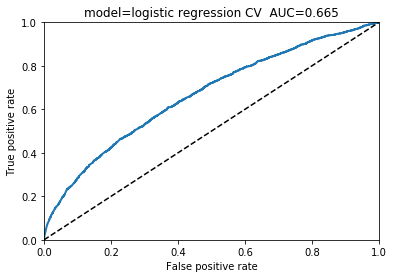

0.665
----------
Importance cutoff = 0.0016
Features passing = 212
Kept length = 212
(35164, 212)
Resulting AUC = 0.665


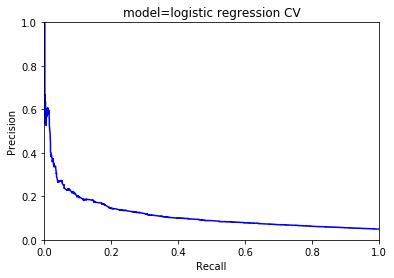

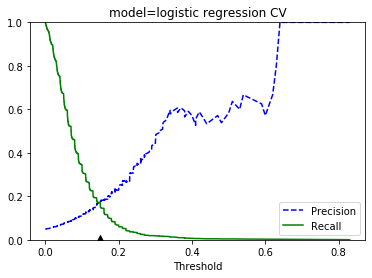

Confusion matrix for threshold = 0.15:
[[32162  1278]
 [ 1459   265]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     33440
           1       0.17      0.15      0.16      1724

    accuracy                           0.92     35164
   macro avg       0.56      0.56      0.56     35164
weighted avg       0.92      0.92      0.92     35164



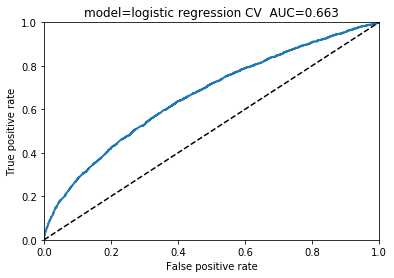

0.663
----------
Importance cutoff = 0.0018
Features passing = 180
Kept length = 180
(35164, 180)
Resulting AUC = 0.663


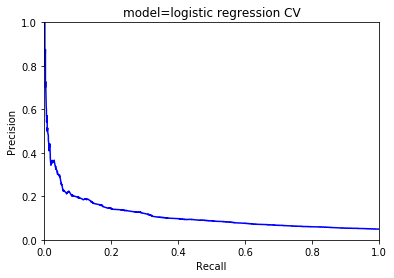

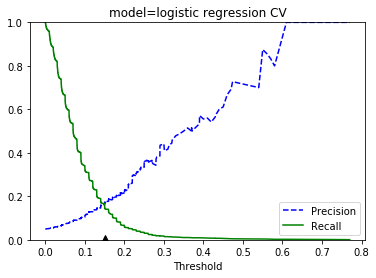

Confusion matrix for threshold = 0.15:
[[32166  1274]
 [ 1469   255]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     33440
           1       0.17      0.15      0.16      1724

    accuracy                           0.92     35164
   macro avg       0.56      0.55      0.56     35164
weighted avg       0.92      0.92      0.92     35164



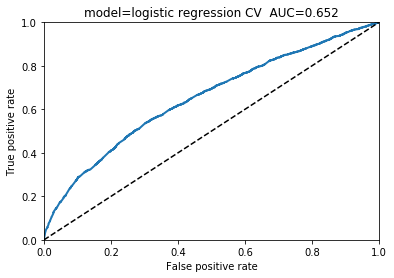

0.652
----------
Importance cutoff = 0.002
Features passing = 147
Kept length = 147
(35164, 147)
Resulting AUC = 0.652


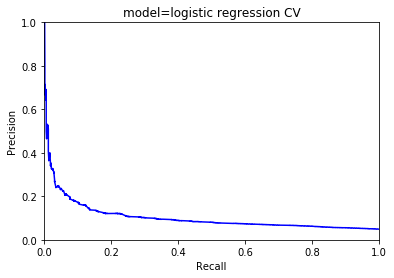

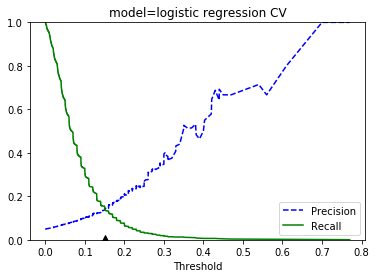

Confusion matrix for threshold = 0.15:
[[31953  1487]
 [ 1488   236]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     33440
           1       0.14      0.14      0.14      1724

    accuracy                           0.92     35164
   macro avg       0.55      0.55      0.55     35164
weighted avg       0.92      0.92      0.92     35164



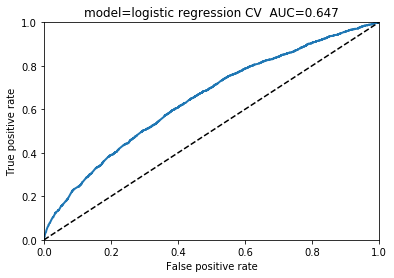

0.647
----------
Importance cutoff = 0.003
Features passing = 64
Kept length = 64
(35164, 64)
Resulting AUC = 0.647


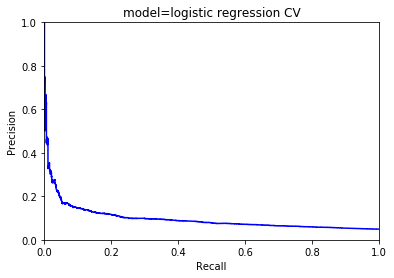

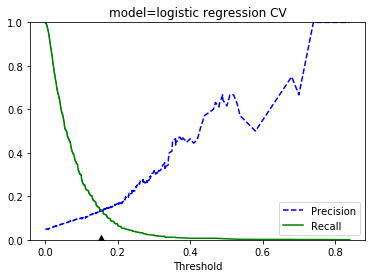

Confusion matrix for threshold = 0.15:
[[31949  1491]
 [ 1492   232]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     33440
           1       0.13      0.13      0.13      1724

    accuracy                           0.92     35164
   macro avg       0.55      0.54      0.55     35164
weighted avg       0.92      0.92      0.92     35164



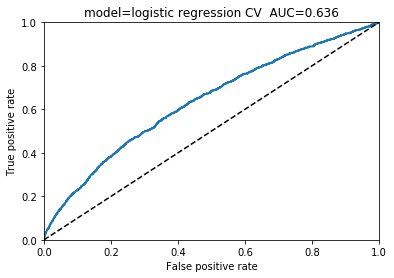

0.636
----------
Importance cutoff = 0.004
Features passing = 32
Kept length = 32
(35164, 32)
Resulting AUC = 0.636


In [26]:
from sklearn.feature_selection import SelectFromModel
#function to run cross validation
def cross_val_eval(model, X_eval, y_eval):
    probs_rf_cv = cross_val_predict(model, X_eval, y_eval, cv=4, method="predict_proba", n_jobs=4)
    scores_rf_cv = probs_rf_cv[:, 1]
    rf_perf_cv = get_model_performance('logistic regression CV', X_train, scores_rf_cv, y_train, pos_label=1)
    print(rf_perf_cv['auc'])
    return(rf_perf_cv['auc'])

#set up importance cutoffs
importance_thresholds = [0.0002,
                         0.0004,
                         0.0006,
                         0.0008,
                         0.001,
                         0.0012,
                         0.0014,
                         0.0016,
                         0.0018,
                         0.002,
                         0.003,
                         0.004]
auc_results = []
for it in importance_thresholds:
    sel = SelectFromModel(estimator=rf_opt,threshold = it, prefit=True)
    passing_count = np.sum(sel.get_support())
    indices = np.argsort(importances)[::-1]
    features = X_train_fs.columns[sel.get_support()]
    X_it = X_train_fs.loc[:, features]
    auc = cross_val_eval(rf_opt, X_it, y_train_fs)
    auc_results.append(auc)
    print('----------')
    print('Importance cutoff = {}'.format(it))
    print('Features passing = {}'.format(passing_count))
    print('Kept length = {}'.format(len(features)))
    print(X_it.shape)
    print('Resulting AUC = {}'.format(auc))

#### plot importance cutoff results

In [34]:
import plotly.graph_objects as go
it_res = pd.DataFrame({'importance cutoff':importance_thresholds,
                     'AUC':auc_results})
print(it_res)
peak = it_res.loc[it_res['AUC']==max(it_res['AUC']),:]
if (peak.shape[0]>1):
    peak = peak.loc[peak['importance cutoff']==max(peak['importance cutoff']),:]
peak_it = float(peak['importance cutoff'])
peak_auc = float(peak['AUC'])


fig = go.Figure()
#add precision trace
fig.add_trace(go.Scatter(x=it_res['importance cutoff'],
                         y=it_res['AUC'],
                         mode='lines',
                         name='AUC',
                         marker_color='grey'))

fig.add_trace(go.Scatter(x=[peak_it],
                         y=[peak_auc],
                         mode="markers",
                         name="importance cutoff = {}".format(peak_it),
                         marker_color='grey',
                         marker=dict(size=[12])))
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)',
                  yaxis_title='AUC',
                  xaxis_title='importance cutoff')
fig.show()

    importance cutoff    AUC
0              0.0002  0.673
1              0.0004  0.666
2              0.0006  0.668
3              0.0008  0.666
4              0.0010  0.672
5              0.0012  0.676
6              0.0014  0.662
7              0.0016  0.665
8              0.0018  0.663
9              0.0020  0.652
10             0.0030  0.647
11             0.0040  0.636


## select importance cutoff

In [39]:
#use fit RF model for feature selection
from sklearn.feature_selection import SelectFromModel
import plotly.express as px
sel = SelectFromModel(estimator=rf_opt, threshold = peak_it, prefit=True)
np.sum(sel.get_support())

#write out for slide figures
selection_results = pd.DataFrame({'feature':X_train_fs.columns,
                                 'importance':rf_opt.feature_importances_,
                                 'pass':sel.get_support()}).sort_values('importance', ascending=False)
selection_results.to_csv('../data/for_plotting/selectionImportances.csv',index=False)

#slice for selected features
select_dat = cdat.loc[:,list(X_train_fs.columns[sel.get_support()])]

#print out results
plt_dat = pd.DataFrame({'importance':importances})
fig = px.histogram(plt_dat.loc[(plt_dat['importance']) & (plt_dat['importance']>0),:],
                                x='importance',
                                nbins=500,
                                color_discrete_sequence=['grey'])
fig.update_layout(title='Feature Importance',
                  xaxis_title="Gini importance",
                  yaxis_title='Count',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show()


#print results
print('selected feature importance cutoff = {}'.format(peak_it))
print('total passing features = {}'.format(np.sum(sel.get_support())))
print('feature matrix shape:')
print(select_dat.shape)

TypeError: unsupported operand type(s) for &: 'float' and 'bool'

### retrieve training and test sets

In [37]:
X_train = select_dat.loc[train_hadm_ids,:]
y_train = y[train_hadm_ids]
X_test = select_dat.loc[test_hadm_ids,:]
y_test = y[test_hadm_ids]
print(X_train.shape)
print(np.sum(y_train))
print(X_test.shape)
print(np.sum(y_test))

(35164, 294)
1724
(8792, 294)
431


## write out

In [38]:
import joblib
joblib.dump(X_train, my_local_data_dir + 'X_train.joblib')
joblib.dump(y_train, my_local_data_dir + 'y_train.joblib')
joblib.dump(X_test, my_local_data_dir + 'X_test.joblib')
joblib.dump(y_test, my_local_data_dir + 'y_test.joblib');